Постановка задачи

В этой же папке на диске лежит файл dataset.csv

Ваша задача провести анализ данных, построить и оценить модель классификации. Выбор метрик и моделей за вами. Решение должно быть загружено в формате .ipynb или .html

Оценка работ будет производиться по следующим критериям: 

- Качественный EDA
- Корректные и обоснованные трансформации данных
- Корректное и обоснованное обучение и оценка модели
- Качество кода и чистота jupyter notebook


Описание данных

Это набор данных HR. Задача состоит в том, чтобы проверить, получил ли сотрудник повышение или нет.
Названия колонок:
	•	employee_id
	•	department
	•	region
	•	education
	•	gender
	•	recruitment_channel
	•	nooftrainings
	•	age
	•	previousyearrating
	•	lengthofservice
	•	KPIs_met >80%
	•	awards_won?
	•	avgtrainingscore
	•	is_promoted

Если по названию колонки все еще не понятно, что в ней содержится, мы ожидаем, что вы сделаете свои предположения на основе анализа данных


In [1]:
import warnings
import os
import os.path as osp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("dataset.csv")
df

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


In [3]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
df.describe(include='all')

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808,54808,52399,54808,54808,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
unique,NaN,9,34,3,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Sales & Marketing,region_2,Bachelor's,m,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,16840,12343,36669,38496,30446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,39195.830627,NaN,NaN,NaN,NaN,NaN,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,NaN,NaN,NaN,NaN,NaN,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,NaN,NaN,NaN,NaN,NaN,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,NaN,NaN,NaN,NaN,NaN,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,NaN,NaN,NaN,NaN,NaN,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000


In [5]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [7]:
missing_values = df.isnull().sum()

data_types = df.dtypes

In [8]:
miss_v_df = pd.DataFrame(zip(*[missing_values.index, missing_values.values, data_types.values]),
                         columns=["columns_name", "missing_values", "data_types"])
miss_v_df

,columns_name,missing_values,data_types
0,employee_id,0,int64
1,department,0,object
2,region,0,object
3,education,2409,object
4,gender,0,object
5,recruitment_channel,0,object
6,no_of_trainings,0,int64
7,age,0,int64
8,previous_year_rating,4124,float64
9,length_of_service,0,int64


`is_promoted` <- Наш таргет.

In [9]:
all_columns = ["department", "region", "education", "gender", "recruitment_channel", "no_of_trainings", "age",
               "previous_year_rating", "length_of_service", "KPIs_met >80%", "awards_won?", "avg_training_score",
               "is_promoted"]

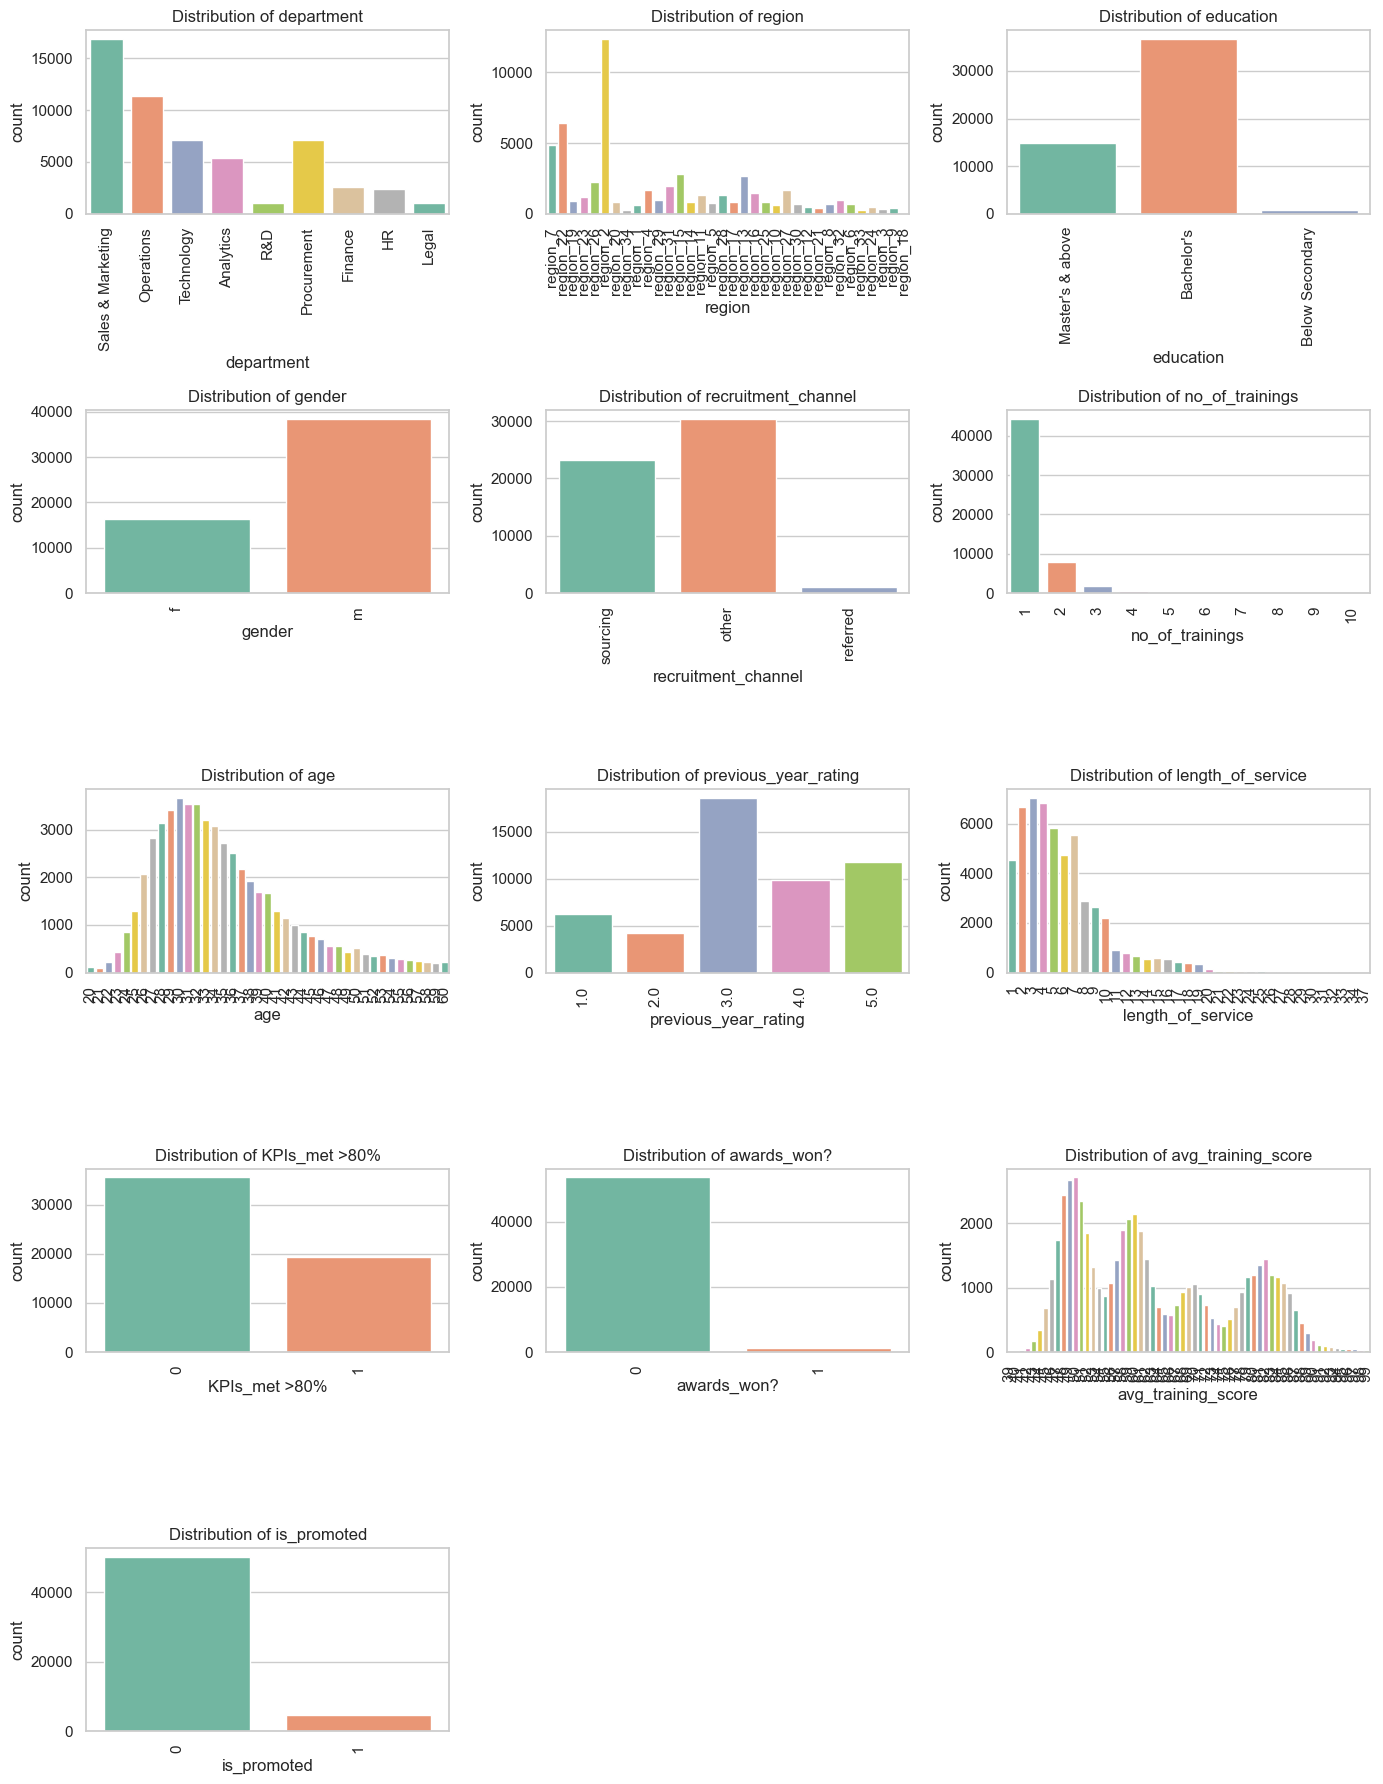

In [10]:
figsize = (14, 18)
plt.figure(figsize=figsize)

for i, column in enumerate(all_columns, 1):
    plt.subplot(5, 3, i)
    sns.countplot(data=df, x=column, palette='Set2')
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

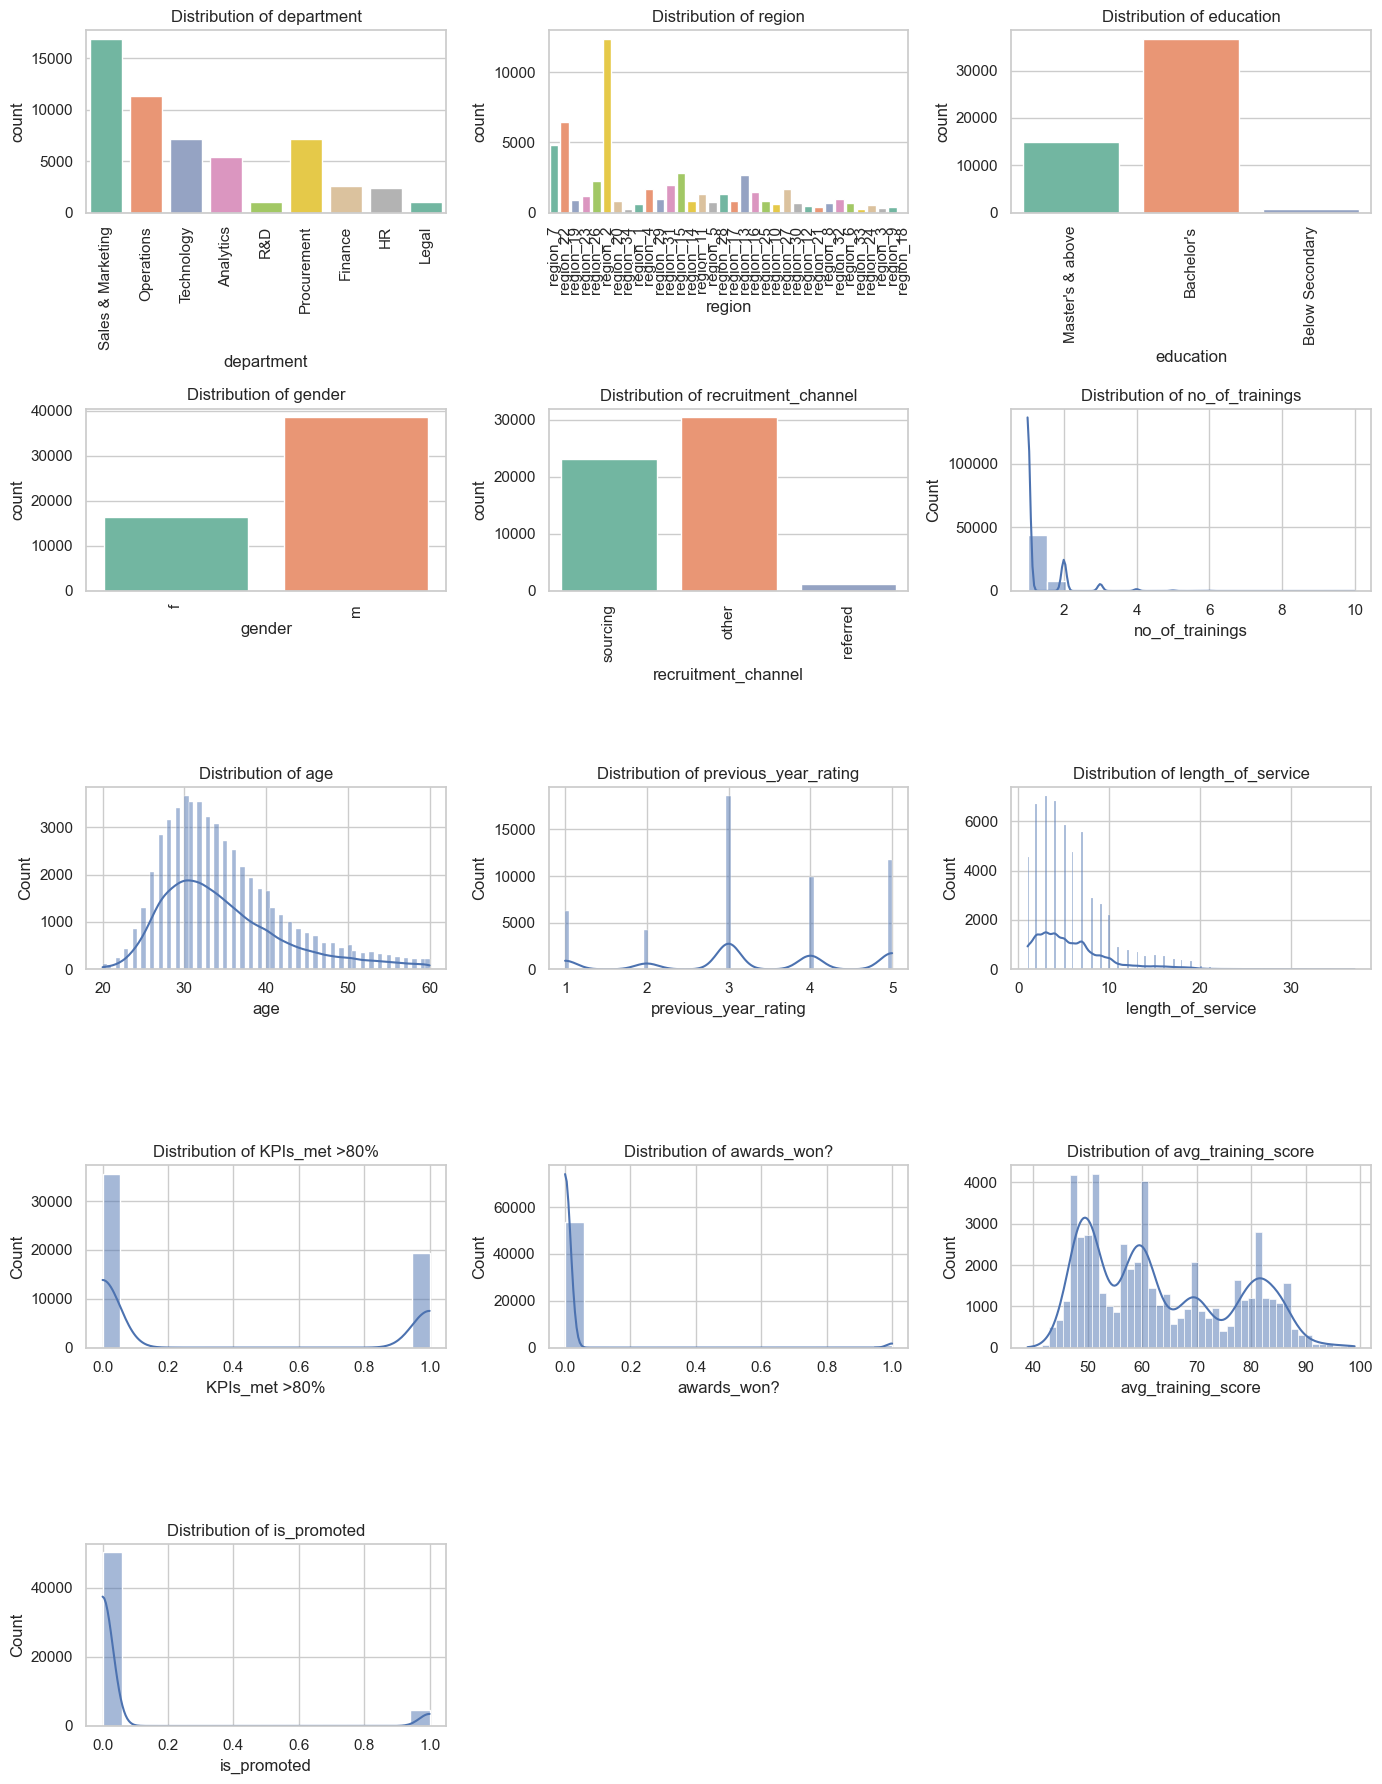

In [11]:
plt.figure(figsize=figsize)

for i, column in enumerate(all_columns, 1):
    plt.subplot(5, 3, i)
    if df[column].dtype == 'object':
        sns.countplot(data=df, x=column, palette='Set2')
        plt.xticks(rotation=90)
    else:
        sns.histplot(df[column], kde=True, palette='Set2')
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()


In [12]:
numerical_features = ['age', 'length_of_service', 'avg_training_score']
categorical_features = ['awards_won?', 'KPIs_met >80%', 'department', 'region', 'education', 'gender',
                        'previous_year_rating', 'no_of_trainings', 'recruitment_channel']

Давайте посмотрим чем можно заполнить пропуски

In [13]:
education_counts = df['education'].value_counts()
education_mode = education_counts.idxmax()
education_mode

"Bachelor's"

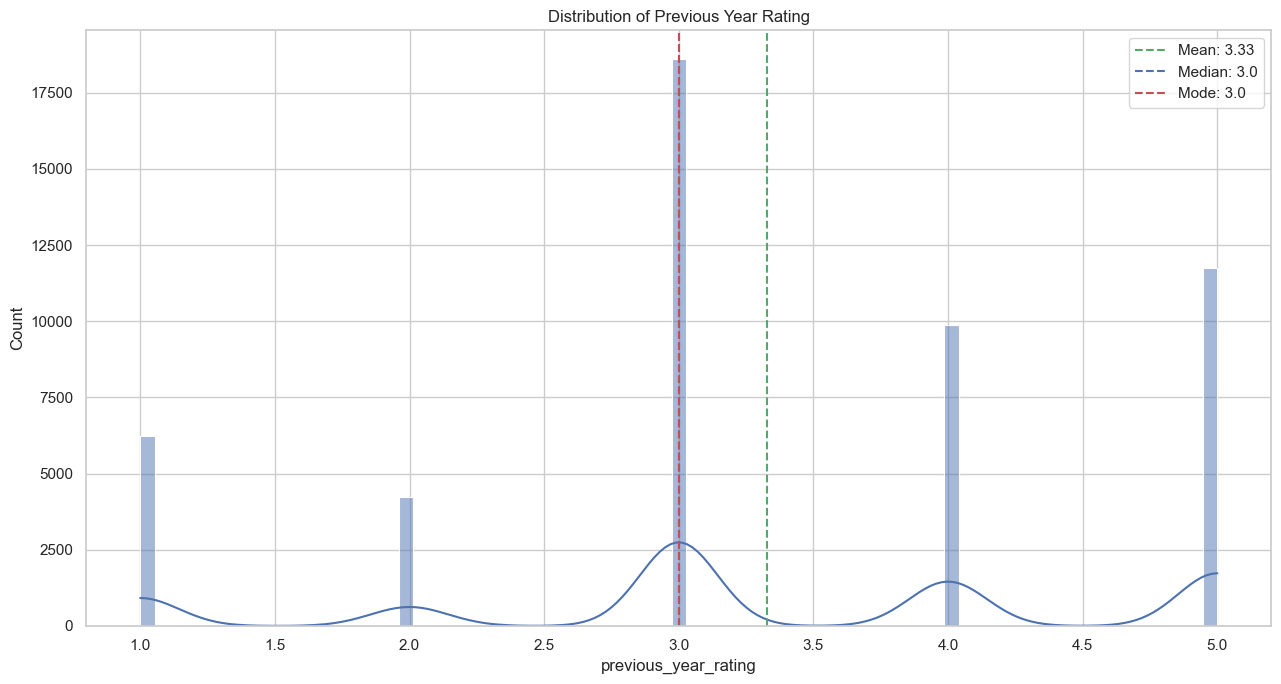

In [14]:
previous_year_rating_mean = df['previous_year_rating'].mean()
previous_year_rating_median = df['previous_year_rating'].median()
previous_year_rating_mode = df['previous_year_rating'].mode()[0]

plt.figure(figsize=(25, 7))
plt.subplot(1, 2, 2)
sns.histplot(df['previous_year_rating'], kde=True, palette='Set2')
plt.axvline(previous_year_rating_mean, color='g', linestyle='--', label=f'Mean: {previous_year_rating_mean:.2f}')
plt.axvline(previous_year_rating_median, color='b', linestyle='--', label=f'Median: {previous_year_rating_median}')
plt.axvline(previous_year_rating_mode, color='r', linestyle='--', label=f'Mode: {previous_year_rating_mode}')
plt.title('Distribution of Previous Year Rating')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
df['education'].fillna('Bachelor\'s', inplace=True)
df['previous_year_rating'].fillna(3.0, inplace=True)

In [16]:
missing_values = df.isnull().sum()

data_types = df.dtypes

miss_v_df = pd.DataFrame(zip(*[missing_values.index, missing_values.values, data_types.values]),
                         columns=["columns_name", "missing_values", "data_types"])
miss_v_df

,columns_name,missing_values,data_types
0,employee_id,0,int64
1,department,0,object
2,region,0,object
3,education,0,object
4,gender,0,object
5,recruitment_channel,0,object
6,no_of_trainings,0,int64
7,age,0,int64
8,previous_year_rating,0,float64
9,length_of_service,0,int64


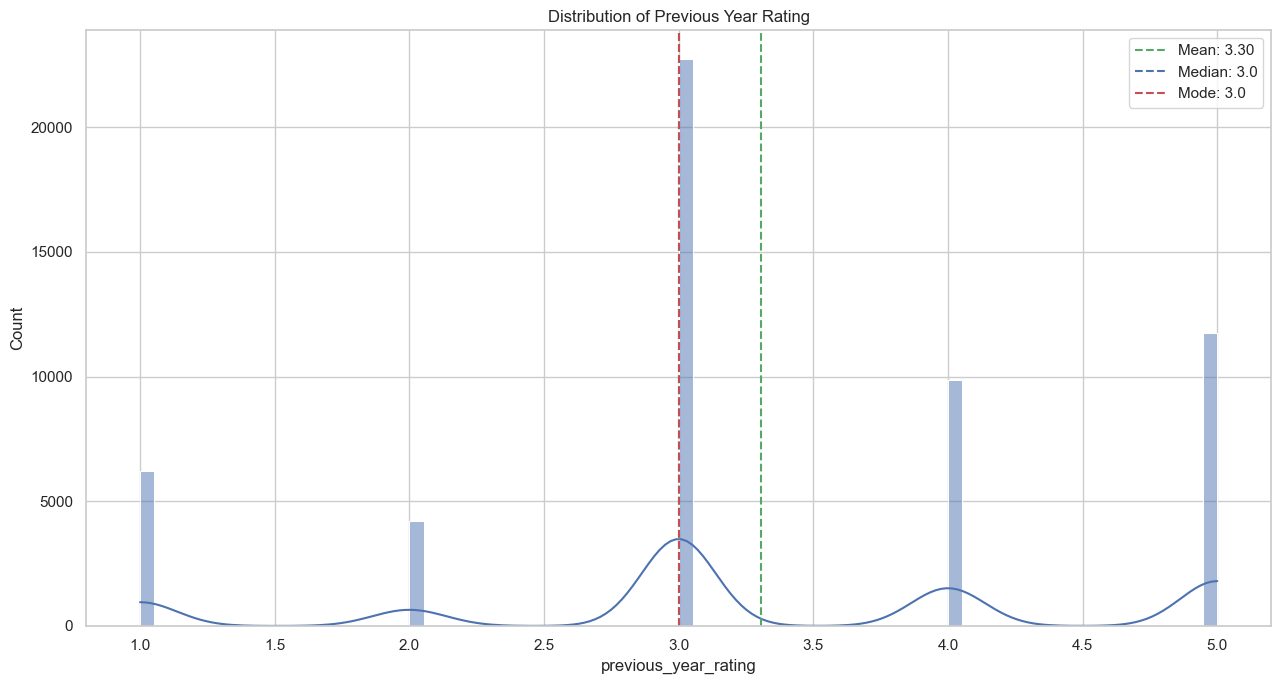

In [17]:
previous_year_rating_mean = df['previous_year_rating'].mean()
previous_year_rating_median = df['previous_year_rating'].median()
previous_year_rating_mode = df['previous_year_rating'].mode()[0]

plt.figure(figsize=(25, 7))
plt.subplot(1, 2, 2)
sns.histplot(df['previous_year_rating'], kde=True, palette='Set2')
plt.axvline(previous_year_rating_mean, color='g', linestyle='--', label=f'Mean: {previous_year_rating_mean:.2f}')
plt.axvline(previous_year_rating_median, color='b', linestyle='--', label=f'Median: {previous_year_rating_median}')
plt.axvline(previous_year_rating_mode, color='r', linestyle='--', label=f'Mode: {previous_year_rating_mode}')
plt.title('Distribution of Previous Year Rating')
plt.legend()

plt.tight_layout()
plt.show()

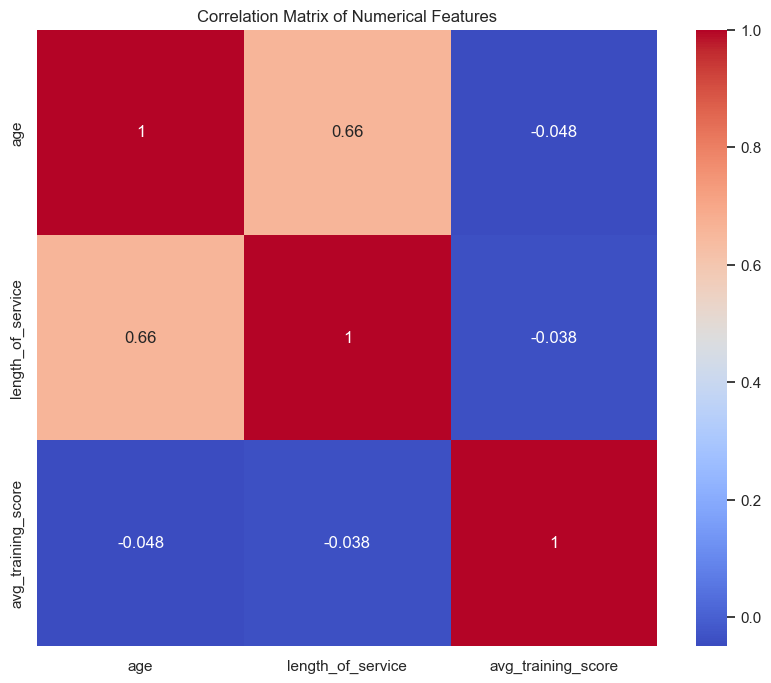

In [18]:
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Существует умеренная положительная корреляция (0,66) между возрастом и продолжительностью трудового стажа, что ожидаемо, поскольку пожилые сотрудники, как правило, имеют более длительный стаж работы

Показатель `avg_training_score` показывает очень слабую корреляцию как с возрастом (-0,048), так и с продолжительностью трудового стажа (-0,038), что указывает на то, что показатели обучения относительно независимы от возраста или стажа сотрудника.

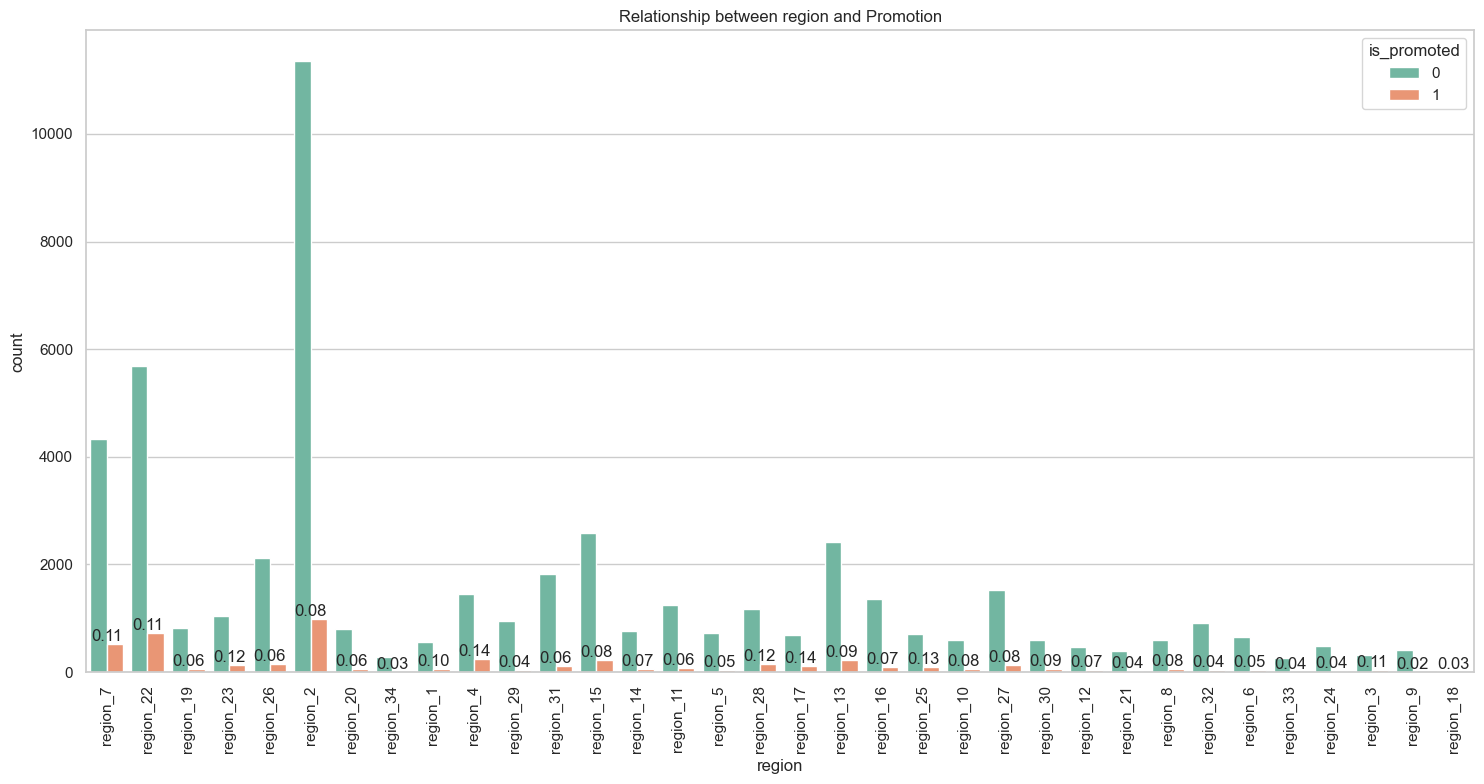

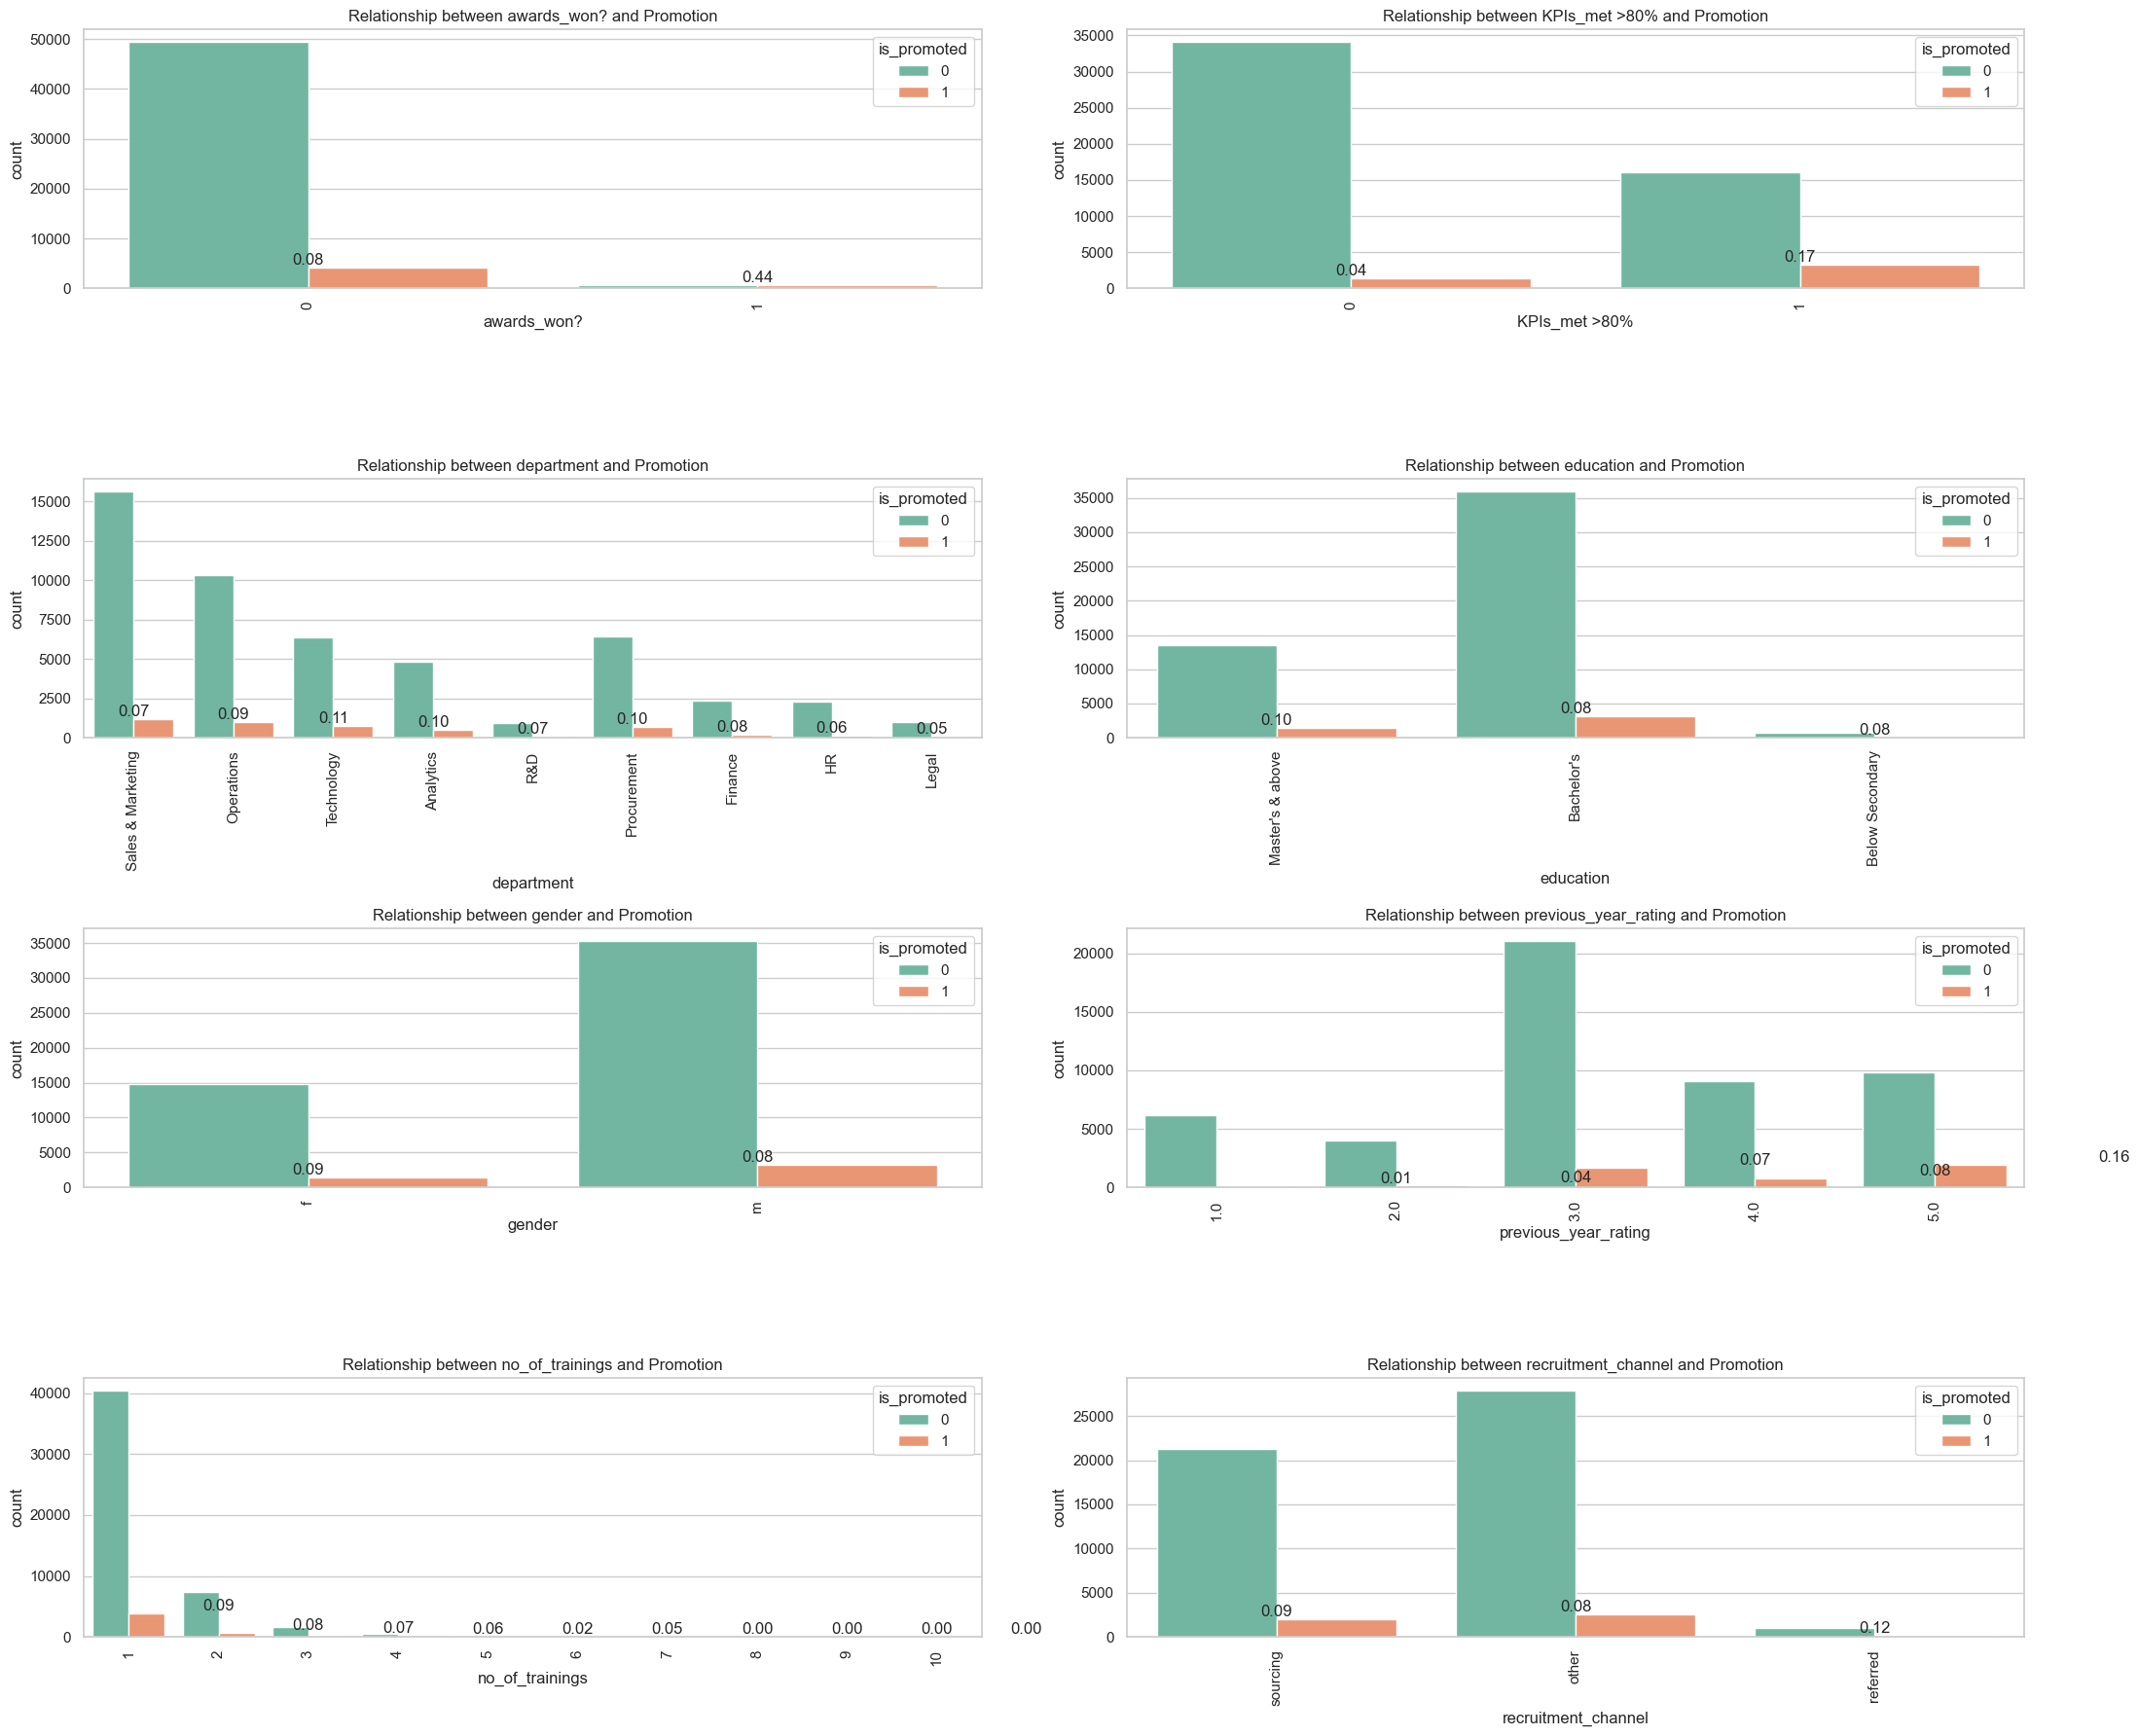

In [52]:
plt.figure(figsize=(15, 8))


def plot_promote_rate(df, column):
    sns.countplot(data=df, x=column, hue='is_promoted', palette='Set2')
    plt.title(f'Relationship between {column} and Promotion')
    plt.xticks(rotation=90)

    # Calculate and add ratios
    uniq_values_of_column = df[column].unique()
    for uniq_value_of_column in uniq_values_of_column:
        count_promoted = df[(df[column] == uniq_value_of_column) & (df["is_promoted"] == 1)].shape[0]
        count_not_promoted = df[(df[column] == uniq_value_of_column) & (df["is_promoted"] == 0)].shape[0]
        ratio = count_promoted / (count_not_promoted + count_promoted)
        plt.text(uniq_value_of_column, count_promoted, f'{ratio:.2f}', ha='center', va='bottom')


plot_promote_rate(df, column="region")
plt.tight_layout()
plt.show()

plt.figure(figsize=(22, 18))

categorical_features_except_region = [c for c in categorical_features if c != "region"]

for i, column in enumerate(categorical_features_except_region, 1):
    plt.subplot(4, 2, i)
    plot_promote_rate(df, column)

plt.tight_layout()
plt.show()


### Анализ взаимосвязей между категориальными признаками и статусом повышения

1. **Награды**:
   - Сотрудники, получившие награды, имеют значительно более высокий процент повышения (44%) по сравнению с теми, кто не получал награды (8%).

2. **KPIs выполнены >80%**:
   - Сотрудники, выполнившие более 80% своих KPIs, имеют более высокий процент повышения (17%) по сравнению с теми, кто этого не сделал (4%).

3. **Отдел**:
   - Наибольший процент повышений наблюдается в отделах `Технологии` (11%) и `Аналитика` (10%), в то время как в других отделах процент повышений колеблется от 5% до 10%.

4. **Регион**:
   - Повышения распределены по всем регионам, с процентом повышения, варьирующимся от 2% до 14%. Наибольший процент повышений наблюдается в регионах `region_4` (14%) и `region_1` (12%).

5. **Образование**:
   - Сотрудники с образованием уровня `Магистр и выше` имеют наибольший процент повышения (10%) по сравнению с `Бакалавром` (8%) и `Ниже среднего` (8%).

6. **Пол**:
   - Мужчины и женщины имеют схожие показатели повышения (8% и 9% соответственно).

7. **Рейтинг за предыдущий год**:
   - Высокие рейтинги за предыдущий год (4 и 5) ассоциируются с более высоким процентом повышений (7% и 16% соответственно) по сравнению с низкими рейтингами (1% для рейтинга 2 и 4% для рейтинга 3).

8. **Количество тренировок**:
   - Сотрудники, прошедшие больше тренировок (2-3), имеют более высокий процент повышения (8% и 7% соответственно) по сравнению с теми, у кого была только одна тренировка (8%).

9. **Канал набора**:
   - Канал `sourcing` имеет более высокий процент повышений (9%) по сравнению с `other` (8%) и `referred` (12%).
